In [1]:
# Display settings
## Auto reload modules & inline plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dt #For inputing any date or time information
from datetime import timezone #For inputing timezones
from google.cloud import bigquery          #The BigQuery API
import matplotlib.pyplot as plt      #For plotting
import numpy as np                         #For scientific computation
import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import pydata_google_auth                  #For authentication against Google 
import pandas as pd                        #For data manipulation and bgq --> pandas conversion
import pandas_gbq as pd_gbq #Import BigQuery data to create a pandas dataframe
import plotly.graph_objects as go # interactive plots
import pytz #For timezone calculations
import seaborn as sns                #For plotting
import warnings
import datetime

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

In [4]:
query = """
SELECT
  CUSTOMER_NUMBER,
  ENTERPRISE_ACCOUNT_NO,
  ENTERPRISE_ACCOUNT_NAME,
  NATIONAL_ACCOUNT,
  PAYER,
  DOCUMENT_DATE_IN_DOCUMENT,
  DOCUMENT_TYPE,
  POSTING_KEY_NAME,
  AMOUNT_IN_LOCAL_CURRENCY,
  CREDIT_CONTROL_AREA,
  AR_STATUS,
  PAYMENT_DATE
  
FROM
  `edna-data-pr-cah.VW_CORP_GFSS_NP.VW_AR_AGING`
WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))
ORDER BY
  PAYMENT_DATE
"""

<font color='red'>check on: WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))</font> 

In [5]:
# Import the data with imputation
bqclient = bigquery.Client()
df = bqclient.query(query).to_dataframe()

In [6]:
df

,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE
0,0010002428,7100000101,7100000101 - KAISER PERMANENTE,,None,2021-06-18,DH,06 - Payment difference,73.140000000,Z2140,CLEAR,None
1,0031001295,,,,None,2021-05-27,DH,06 - Payment difference,1487.330000000,Z2140,OPEN,None
2,0010024136,7100016784,7100016784 - THERMO FISHER SCIENTIFIC,,None,2021-06-18,DH,16 - Payment difference,-2.950000000,Z2140,CLEAR,None
3,0010024136,7100016784,7100016784 - THERMO FISHER SCIENTIFIC,,None,2021-06-09,DH,16 - Payment difference,-71.430000000,Z2140,CLEAR,None
4,0011000212,7100000882,7100000882 - AMERISOURCE,,None,2021-01-08,DL,17 - Other clearing,-866.250000000,Z2140,CLEAR,None
...,...,...,...,...,...,...,...,...,...,...,...,...
53110085,2057223688,7100000645,7100000645 - UNIV OF MIAMI HEALTH SYSTEM,0000027009,2057223688,2023-05-25,ZF,01 - Invoice,59495.160000000,PD,CLEAR,2203-06-21
53110086,0011098170,7100004978,7100004978 - ASC CENTER FOR CHANGE LLC,,None,2222-04-26,DL,16 - Payment difference,-376.180000000,Z2140,CLEAR,2222-04-26
53110087,0011098170,7100004978,7100004978 - ASC CENTER FOR CHANGE LLC,,None,2222-04-26,DL,06 - Payment difference,376.180000000,Z2140,CLEAR,2222-04-26
53110088,0010011780,7100000117,7100000117 - AVERA HEALTH,,None,5019-05-25,DL,17 - Other clearing,-328.000000000,Z2140,CLEAR,5019-05-25


In [47]:
def calc_WAPD(df):
    df['WAPD']=""
    for i in range(len(df)):
        WAPD_dates = (df['PAYMENT_DATE'] > df['90 days ago'][i]) & (df['PAYMENT_DATE'] <= df['PAYMENT_DATE'][i])
        df2 = df.loc[WAPD_dates]
        
        df['WAPD'][i]= df2['Weighted Invoice Value'].sum()/df2['AMOUNT_IN_LOCAL_CURRENCY'].sum()

In [48]:
def search_customer(CUSTOMER_NUMBER):
    CUSTOMER_df=df.query('CUSTOMER_NUMBER == @CUSTOMER_NUMBER')
    CUSTOMER_df=CUSTOMER_df.query('POSTING_KEY_NAME == "01 - Invoice" & AR_STATUS == "CLEAR"')
    CUSTOMER_df.reset_index(inplace = True)
    
    
    CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = CUSTOMER_df['PAYMENT_DATE']
    d = datetime.timedelta(days = 90)
    days_ago = (current - d)
    CUSTOMER_df['90 days ago']= days_ago
    WAPD_dates = (CUSTOMER_df['PAYMENT_DATE'] > CUSTOMER_df['90 days ago'][0]) & (CUSTOMER_df['PAYMENT_DATE'] <= CUSTOMER_df['PAYMENT_DATE'][0])
    df2 = CUSTOMER_df.loc[WAPD_dates]
    
    calc_WAPD(CUSTOMER_df)

    return CUSTOMER_df

In [9]:
def search_EAN(ENTERPRISE_ACCOUNT_NAME):
    None

In [10]:
def search_EAN(ENTERPRISE_ACCOUNT_NAME):
    None

# **********************************************************************************************************

In [11]:
CONVERSIO_HEALTH_df=df.query('CUSTOMER_NUMBER == "2057194397"')

In [12]:
CONVERSIO_HEALTH_df=CONVERSIO_HEALTH_df.query('POSTING_KEY_NAME == "01 - Invoice" & AR_STATUS == "CLEAR"')

In [13]:
CONVERSIO_HEALTH_df.reset_index(inplace = True)

In [14]:
CONVERSIO_HEALTH_df

,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE
0,2227397,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-10-11,ZF,01 - Invoice,0.020000000,PD,CLEAR,None
1,2348308,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-10-10,ZF,01 - Invoice,0.020000000,PD,CLEAR,None
2,7589796,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-04,ZF,01 - Invoice,38.500000000,PD,CLEAR,2022-09-02
3,7604479,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,203.880000000,PD,CLEAR,2022-09-02
4,7604480,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-01,ZF,01 - Invoice,765.070000000,PD,CLEAR,2022-09-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,52718686,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-07,ZF,01 - Invoice,1258.880000000,PD,CLEAR,2023-09-08
553,52722306,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-09,ZF,01 - Invoice,2319.250000000,PD,CLEAR,2023-09-08
554,52723081,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-11,ZF,01 - Invoice,456.220000000,PD,CLEAR,2023-09-08
555,52724664,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-10,ZF,01 - Invoice,2862.890000000,PD,CLEAR,2023-09-08


In [15]:
# CONVERSIO_HEALTH_df[''] = float(CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY'])
CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY']=CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))

In [16]:
CONVERSIO_HEALTH_df.query('2179.26 >=AMOUNT_IN_LOCAL_CURRENCY >= 2178.26')

,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE
481,46909018,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-06-29,ZF,01 - Invoice,2179.2600,PD,CLEAR,2023-07-21
530,51060612,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-07-28,ZF,01 - Invoice,2179.2600,PD,CLEAR,2023-08-25


### Sub Payment Date from Invoice Date 

In [17]:
CONVERSIO_HEALTH_df['Sub Payment Date from Invoice Date']=(CONVERSIO_HEALTH_df['PAYMENT_DATE']-CONVERSIO_HEALTH_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days

### Weighted Invoice Value

In [18]:
CONVERSIO_HEALTH_df['Weighted Invoice Value']= CONVERSIO_HEALTH_df['Sub Payment Date from Invoice Date']*CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY']

### WAPD 

=SUM(*Weighted Invoice Value* 8:AR15)/SUM(*AMOUNT_IN_LOCAL_CURRENCY* 8:AS15)

In [19]:
# CONVERSIO_HEALTH_df['WAPD']= CONVERSIO_HEALTH_df['Weighted Invoice Value']/CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY']

In [20]:
import datetime
current = CONVERSIO_HEALTH_df['PAYMENT_DATE']
d = datetime.timedelta(days = 90)
days_ago = current - d
CONVERSIO_HEALTH_df['90 days ago']= days_ago

In [21]:
WAPD_dates = (CONVERSIO_HEALTH_df['PAYMENT_DATE'] > CONVERSIO_HEALTH_df['90 days ago'][0]) & (CONVERSIO_HEALTH_df['PAYMENT_DATE'] <= CONVERSIO_HEALTH_df['PAYMENT_DATE'][0])
df2 = CONVERSIO_HEALTH_df.loc[WAPD_dates]

In [22]:
df2

,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,Sub Payment Date from Invoice Date,Weighted Invoice Value,90 days ago


In [26]:
def calc_WAPD():
    for i in range(len(CONVERSIO_HEALTH_df)):
        WAPD_dates = (CONVERSIO_HEALTH_df['PAYMENT_DATE'] > CONVERSIO_HEALTH_df['90 days ago'][i]) & (CONVERSIO_HEALTH_df['PAYMENT_DATE'] <= CONVERSIO_HEALTH_df['PAYMENT_DATE'][i])
        df2 = CONVERSIO_HEALTH_df.loc[WAPD_dates]
        
        CONVERSIO_HEALTH_df['WAPD']= df2['Weighted Invoice Value'].sum()/df2['AMOUNT_IN_LOCAL_CURRENCY'].sum()

In [28]:
calc_WAPD()
CONVERSIO_HEALTH_df.head()

,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,Sub Payment Date from Invoice Date,Weighted Invoice Value,90 days ago,WAPD
0,2227397,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-10-11,ZF,01 - Invoice,0.0200,PD,CLEAR,None,NaN,NaN,NaT,26.6904
1,2348308,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-10-10,ZF,01 - Invoice,0.0200,PD,CLEAR,None,NaN,NaN,NaT,26.6904
2,7589796,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-04,ZF,01 - Invoice,38.5000,PD,CLEAR,2022-09-02,29.0000,1116.5000,2022-06-04,26.6904
3,7604479,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,203.8800,PD,CLEAR,2022-09-02,31.0000,6320.2800,2022-06-04,26.6904
4,7604480,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-01,ZF,01 - Invoice,765.0700,PD,CLEAR,2022-09-02,32.0000,24482.2400,2022-06-04,26.6904


In [29]:
# CONVERSIO_HEALTH_df['total WAPD']= CONVERSIO_HEALTH_df['Weighted Invoice Value'].sum()/CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY'].sum()
# CONVERSIO_HEALTH_df

# Visualization

## Customer

In [30]:
df['CUSTOMER_NUMBER'].unique()

array(['0010002428', '0031001295', '0010024136', ..., '0011378980',
       '0011126067', '2057156557'], dtype=object)

In [49]:
customer = "2057194397"
t = search_customer(customer)

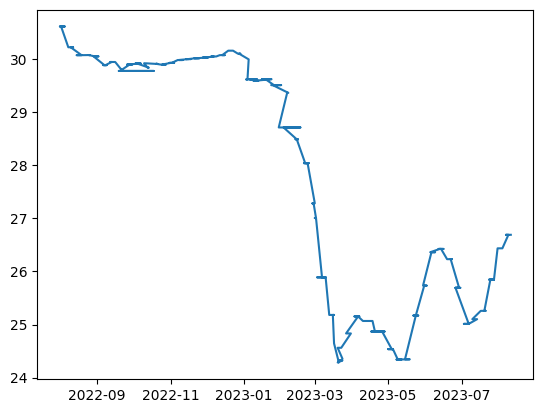

In [51]:
plt.plot(t['DOCUMENT_DATE_IN_DOCUMENT'],t['WAPD'])

## EAN

## National Account